In [1]:
# import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

import seaborn as sns
%matplotlib inline

Using the openml dataset ID:44062 `Brazilian Houses to Rent` <br>

Original raw data with column descriptions:  <br>
https://www.kaggle.com/datasets/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv <br>

The data used, clean: `Brazilian_houses v.8 on OpenML` <br>
https://www.openml.org/search?type=data&status=active&sort=date&id=44062

Used the following cell to get data from OpenML. Commented it so that I do not need to incorporate it in my pipenv virtual env.

In [7]:
# dataset = openml.datasets.get_dataset(44062, download_data=True)
# X, y, categorical_indicator, attribute_names = dataset.get_data(
#     dataset_format="array", target=dataset.default_target_attribute
# )
# df = pd.DataFrame(X, columns=attribute_names)
# df["target"] = y
# df.to_csv("data/brazilian_houses_openml_v8.csv")

In [8]:
df = pd.read_csv("data/brazilian_houses_openml_v8.csv", index_col=0)

In [9]:
df.head()

,city,area,rooms,bathroom,parking_spaces,animal,furniture,hoa_(BRL),rent_amount_(BRL),property_tax_(BRL),fire_insurance_(BRL),target
0,4.0,70.0,2.0,1.0,1.0,0.0,0.0,2065.0,3300.0,211.0,42.0,8.633909
1,4.0,320.0,4.0,4.0,0.0,0.0,1.0,1200.0,4960.0,1750.0,63.0,8.983941
2,2.0,80.0,1.0,1.0,1.0,0.0,1.0,1000.0,2800.0,0.0,41.0,8.253748
3,2.0,51.0,2.0,1.0,0.0,0.0,1.0,270.0,1112.0,22.0,17.0,7.259820
4,4.0,25.0,1.0,1.0,0.0,1.0,1.0,0.0,800.0,25.0,11.0,6.729824


In [18]:
df.columns = df.columns.str.replace("[()]", "", regex=True)
df.columns = df.columns.str.lower()
df.head()

,city,area,rooms,bathroom,parking_spaces,animal,furniture,hoa_brl,rent_amount_brl,property_tax_brl,fire_insurance_brl,target
0,4.0,70.0,2.0,1.0,1.0,0.0,0.0,2065.0,3300.0,211.0,42.0,8.633909
1,4.0,320.0,4.0,4.0,0.0,0.0,1.0,1200.0,4960.0,1750.0,63.0,8.983941
2,2.0,80.0,1.0,1.0,1.0,0.0,1.0,1000.0,2800.0,0.0,41.0,8.253748
3,2.0,51.0,2.0,1.0,0.0,0.0,1.0,270.0,1112.0,22.0,17.0,7.259820
4,4.0,25.0,1.0,1.0,0.0,1.0,1.0,0.0,800.0,25.0,11.0,6.729824


In [13]:
cat_columns = ['city', 'animal', 'furniture']
num_columns = ['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa_brl','rent_amount_brl', 
               'property_tax_brl', 'fire_insurance_brl']
print(f"{cat_columns=}")
print(f"{num_columns=}")

cat_columns=['city', 'animal', 'furniture']
num_columns=['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa_brl', 'rent_amount_brl', 'property_tax_brl', 'fire_insurance_brl']


In [14]:
# Target variable is the rent which log1p-transformed. 
actual_total_rent = np.exp(df["target"]) - 1 

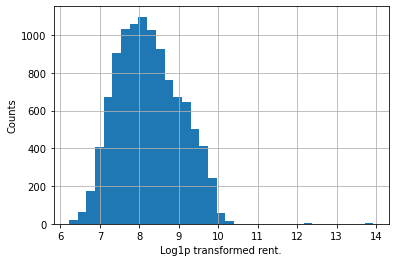

In [17]:
df.target.hist(bins=35)
plt.xlabel("Log1p transformed rent.")
plt.ylabel("Counts")
plt.show()

In [9]:
df.shape

(10692, 12)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                10692 non-null  float32
 1   area                10692 non-null  float32
 2   rooms               10692 non-null  float32
 3   bathroom            10692 non-null  float32
 4   parking_spaces      10692 non-null  float32
 5   animal              10692 non-null  float32
 6   furniture           10692 non-null  float32
 7   hoa_brl             10692 non-null  float32
 8   rent_amount_brl     10692 non-null  float32
 9   property_tax_brl    10692 non-null  float32
 10  fire_insurance_brl  10692 non-null  float32
 11  target              10692 non-null  float64
dtypes: float32(11), float64(1)
memory usage: 543.1 KB


We see that the whole data is free of nulls.

In [11]:
# Look at only numerical values
df.loc[:,num_columns].describe()

,area,rooms,bathroom,parking_spaces,hoa_brl,rent_amount_brl,property_tax_brl,fire_insurance_brl
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000
mean,149.217926,2.506079,2.236813,1.609147,1.174022e+03,3896.245361,366.704346,53.300880
std,537.016479,1.171276,1.407143,1.589505,1.559238e+04,3408.522461,3107.805908,47.767841
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000


Lets see how categorical variables are distributed.
* City takes values from 0 to 4, as integers, 5 cities.
* Furniture and Animal describe binary features: is the house furnitured or does owner NOT allow animals?

In [12]:
print("The percentage of houses that reject animals/pets in the house: {}%".format(np.round(df.animal.mean()*100,1)))

The percentage of houses that reject animals/pets in the house: 22.2%


In [13]:
print("The percentage of furnitured houses: {}%".format(np.round(df.furniture.mean()*100,1)))

The percentage of furnitured houses: 75.6%


We see that it is coded inversely to intuition. 75.6% of houses should be without furniture. (as verifiable on original raw data in Kaggle)

In [14]:
# reversing the code to mean furnitured and animal-permitted.
df.furniture = (df.furniture ==0).astype(int)
print("The percentage of furnitured houses: {}%".format(np.round(df.furniture.mean()*100,1)))
df.animal = (df.animal == 0).astype(int)
print("The percentage of pet-friendly houses: {}%".format(np.round(df.animal.mean()*100,1)))

The percentage of furnitured houses: 24.4%
The percentage of pet-friendly houses: 77.8%


In [15]:
df.groupby('city').mean()

,area,rooms,bathroom,parking_spaces,animal,furniture,hoa_brl,rent_amount_brl,property_tax_brl,fire_insurance_brl,target
city,,,,,,,,,,,
0.0,207.411758,3.020668,2.402226,1.955485,0.740064,0.140700,2324.197021,3664.127930,272.782196,53.675674,8.081089
1.0,137.561554,2.355217,1.960141,1.558030,0.812427,0.130129,628.922607,2364.290771,147.657684,32.388042,7.796197
2.0,103.609390,2.140821,1.725901,1.044426,0.842414,0.267393,491.618622,2337.699951,124.021797,36.425816,7.763974
3.0,105.347771,2.243837,1.756163,0.744171,0.802798,0.270486,1079.432373,3232.904053,256.853424,42.483013,8.168301
4.0,158.899445,2.558858,2.467641,1.877527,0.761339,0.270596,1169.628052,4652.793945,495.701721,62.428909,8.458802


In [16]:
df.groupby('animal').mean()

,city,area,rooms,bathroom,parking_spaces,furniture,hoa_brl,rent_amount_brl,property_tax_brl,fire_insurance_brl,target
animal,,,,,,,,,,,
0,2.964647,109.409088,2.128788,1.925505,1.230219,0.314394,1815.983643,3464.212158,384.182251,46.227695,8.110661
1,2.915584,160.591873,2.613877,2.325758,1.717412,0.223545,990.604004,4019.685791,361.710693,55.321789,8.281054


In [17]:
df.groupby('furniture').mean()

,city,area,rooms,bathroom,parking_spaces,animal,hoa_brl,rent_amount_brl,property_tax_brl,fire_insurance_brl,target
furniture,,,,,,,,,,,
0,2.838363,146.725693,2.559733,2.222483,1.613406,0.798541,1143.810669,3578.460938,364.966248,49.456593,8.148638
1,3.199923,156.950882,2.339601,2.281274,1.595932,0.713354,1267.761719,4882.287109,372.097473,65.229088,8.536564


In [18]:
df.pivot_table(values='target', index='city', columns='rooms').round(2)

rooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,13.0
city,,,,,,,,,,,
0.0,7.43,7.46,7.96,8.77,8.98,9.01,9.03,8.88,NaN,8.71,NaN
1.0,7.36,7.46,8.09,8.69,9.02,8.44,9.01,NaN,NaN,NaN,NaN
2.0,7.38,7.59,8.20,8.57,8.79,8.68,8.78,9.01,NaN,NaN,NaN
3.0,7.67,8.00,8.53,9.01,9.19,9.05,9.55,NaN,NaN,NaN,9.67
4.0,7.86,8.08,8.70,9.21,9.27,9.09,9.10,9.44,9.46,9.27,NaN


We see that rents increase with increasing number of rooms. <br>
City-4 is the most expensive city. then City-3 comes second most expensive city to rent. Others seem comparable.

We can leave the animal and furniture categorical variables as they are since they are binary. We need to OHE the city variable.

In [19]:
# see the percentages of city data in whole dataset.
df['city'].value_counts()

4.0    5887
3.0    1501
0.0    1258
2.0    1193
1.0     853
Name: city, dtype: int64

In [20]:
# From Kaggle csv2 file: I inferred:
city_num2name = {4: 'Sao Paulo', 3: 'Rio de Janeiro', 0:'Belo Horizonte', 2:'Porto Alegre', 1:'Campinas'}
city_name2num = {val:key for key,val in city_num2name.items()}

In [21]:
city_name2num 

{'Sao Paolo': 4,
 'Rio de Janeiro': 3,
 'Belo Horizonte': 0,
 'Porto Alegre': 2,
 'Campinas': 1}

In [22]:
df['city'] = df['city'].map(city_num2name)

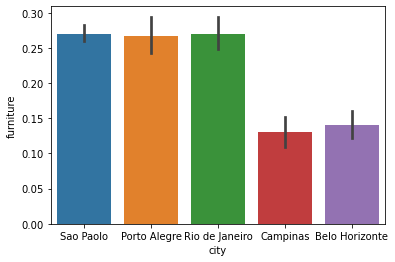

In [23]:
sns.barplot(data=df, x='city', y='furniture')
plt.show()

We see that in city-0 (Belo Horizente) and city-1 (Campinas) have lower portion of their houses furnitured. 

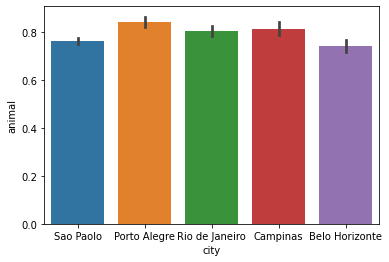

In [24]:
sns.barplot(data=df, x='city', y='animal')
plt.show()

Porte Alegre is the most pet-friendly whereas Belo Horizonte has the least tolerance.

In [25]:
df.corrwith(df["target"]).round(2)

area                  0.18
rooms                 0.60
bathroom              0.71
parking_spaces        0.60
animal                0.09
furniture             0.21
hoa_brl               0.15
rent_amount_brl       0.87
property_tax_brl      0.17
fire_insurance_brl    0.85
target                1.00
dtype: float64

<AxesSubplot:>

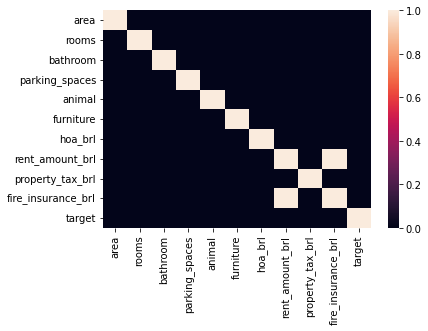

In [26]:
sns.heatmap(df.corr() > 0.9)

In [27]:
df['rent_amount_brl'].corr(df['fire_insurance_brl'])

0.9873431856626529

We can see that rent_amount and fire_insurance are highly correlated, causing multicollinearity. <br>
We can remove one or both of them, I prefer to delete `rent_amounth_brl` to prevent multicollinearity. <br>
Also, the task is to predict total rent amount, majority of which is this column.

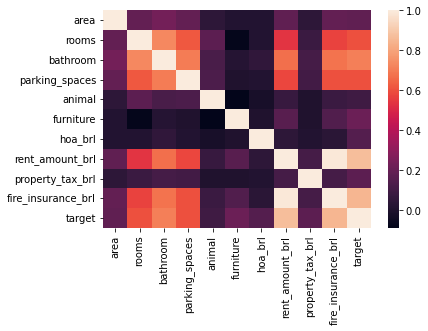

In [28]:
sns.heatmap(df.corr().round(2))
plt.show()

In [29]:
del df['rent_amount_brl']

## Training the data

In [30]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['city'])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42, stratify=df_full_train['city'])

df_train.shape, df_val.shape, df_test.shape

((6414, 11), (2139, 11), (2139, 11))

In [31]:
y_train = df_train.pop('target')
y_val = df_val.pop('target')
y_test = df_test.pop('target')
df_train.shape, df_val.shape, df_test.shape

((6414, 10), (2139, 10), (2139, 10))

In [32]:
# Turn city into 5 columns for 5 cities
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [33]:
X_train.shape, X_val.shape, X_test.shape

((6414, 14), (2139, 14), (2139, 14))

### Base model: Linear regression

In [34]:

mm_scaler = MinMaxScaler()
model = LinearRegression()

X_train_s = mm_scaler.fit_transform(X_train)
X_val_s = mm_scaler.transform(X_val)
X_test_s = mm_scaler.transform(X_test)

model.fit(X_train_s, y_train)

model.score(X_train_s, y_train).round(2)

0.82

In [35]:
feat_importances = {name:val for name, val in zip(dv.get_feature_names_out() , model.coef_)}

In [36]:
sorted(feat_importances.items(), key=lambda x: abs(x[1]), reverse=True)

[('hoa_brl', 6.918186694085346),
 ('fire_insurance_brl', 6.339529942870799),
 ('property_tax_brl', 2.655099728613789),
 ('rooms', 0.8567544071234628),
 ('bathroom', 0.7178296857268301),
 ('area', -0.6150974899659254),
 ('furniture', 0.2228065441221755),
 ('parking_spaces', 0.1986829479209035),
 ('city=Rio de Janeiro', 0.18714388994013414),
 ('city=Sao Paolo', 0.16287210414000822),
 ('city=Porto Alegre', -0.12631085114907886),
 ('city=Belo Horizonte', -0.12469883297069355),
 ('city=Campinas', -0.09900630996037443),
 ('animal', 0.02550746063690118)]

The Homeowners association tax (`hoa_brl`), `fire_insurance_brl` seems to be dominant factor in linear regression with min-max scaling. The features `property_tax_brl`, `rooms`, `bathroom` and `area`  are the next important features. This may change with scaling method applied, i.e. standard scaler. <br>

For this task, robust scaler results in the feature importances order that makes more sense since it is robust to outliers, as shown below. The R2 scores do not change.

In [37]:
rb_scaler = RobustScaler()
model = LinearRegression()

X_train_s = rb_scaler.fit_transform(X_train)
X_val_s = rb_scaler.transform(X_val)
X_test_s = rb_scaler.transform(X_test)

model.fit(X_train_s, y_train)
feat_importances = {name:val for name, val in zip(dv.get_feature_names_out() , model.coef_)}
sorted(feat_importances.items(), key=lambda x: abs(x[1]), reverse=True)

[('fire_insurance_brl', 0.4326682156855435),
 ('furniture', 0.2228065441221761),
 ('city=Rio de Janeiro', 0.1871438899401353),
 ('city=Sao Paolo', 0.16287210414000922),
 ('bathroom', 0.15951770793929448),
 ('city=Porto Alegre', -0.1263108511490771),
 ('city=Belo Horizonte', -0.12469883297069313),
 ('city=Campinas', -0.09900630996037448),
 ('rooms', 0.09519493412482938),
 ('parking_spaces', 0.039736589584180755),
 ('property_tax_brl', 0.031914072129142004),
 ('animal', 0.025507460636901725),
 ('hoa_brl', 0.006678186931868904),
 ('area', -0.0016730481766624866)]

In [38]:
# For this this simple linear regression is meaningless to split data into train/test/val but still lets see.
print("Validation score: {:.2f}".format(model.score(X_val_s, y_val)))
print("Test score: {:.2f}".format(model.score(X_test_s, y_test)))

Validation score: 0.37
Test score: 0.82


### XGBoost

In [39]:
import xgboost as xgb

In [40]:
dtrain = xgb.DMatrix(X_train, label=y_train)

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [41]:
y_train_pred = model.predict(dtrain)
mean_squared_error(y_train, y_train_pred)

0.004304628735925076

In [42]:
dval = xgb.DMatrix(X_val)
dtest = xgb.DMatrix(X_test)

y_val_pred = model.predict(dval)
y_test_pred = model.predict(dtest)

In [43]:
mean_squared_error(y_val, y_val_pred)

0.007401762046229425

In [44]:
mean_squared_error(y_test, y_test_pred)

0.00457727649341731

The results look good. For Xgboost, we can optionally remove the `rent_amount_brl` column from data as it contains far too much of the target variable even though target variable is log-1p-transformed.

In [45]:
# Root mean square error of training for the actual value in BRL
np.sqrt(mean_squared_error(np.expm1(y_train_pred), np.expm1(y_train.values)))

1745.4267340363742

In [46]:
dv.get_feature_names_out()

array(['animal', 'area', 'bathroom', 'city=Belo Horizonte',
       'city=Campinas', 'city=Porto Alegre', 'city=Rio de Janeiro',
       'city=Sao Paolo', 'fire_insurance_brl', 'furniture', 'hoa_brl',
       'parking_spaces', 'property_tax_brl', 'rooms'], dtype=object)

In [47]:
# # it is at index 12.
# ind = list(np.arange(0,14))
# ind.remove(12)
# ind

In [48]:
# X_train = X_train[:,ind]
# X_test = X_test[:,ind]
# X_val = X_val[:,ind]

In [49]:
# X_train.shape, X_val.shape, X_test.shape

In [50]:
dtrain = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(xgb_params, dtrain, num_boost_round=175)
y_train_pred = model.predict(dtrain)
print("Training MSE:")
print(mean_squared_error(y_train, y_train_pred).round(4))

Training MSE:
0.0043


In [51]:
dval = xgb.DMatrix(X_val)
dtest = xgb.DMatrix(X_test)

y_val_pred = model.predict(dval)
y_test_pred = model.predict(dtest)

print("Validation MSE:")
print(mean_squared_error(y_val, y_val_pred).round(4))
print("Test MSE:")
print(mean_squared_error(y_test, y_test_pred).round(4))

Validation MSE:
0.0074
Test MSE:
0.0046


In [52]:
np.expm1(y_train_pred), np.expm1(y_train.values)

(array([2186.262 , 2266.497 , 6763.6104, ..., 2899.8547, 3816.5825,
        3487.8906], dtype=float32),
 array([2176.000471  , 2387.00028445, 6550.99706123, ..., 3006.99896835,
        3840.99845066, 3393.00037704]))

In [53]:
eta_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
results = []

for eta in eta_values:    
    xgb_params = {
        'eta': eta, 
        'max_depth': 3,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=175)
    y_val_pred = model.predict(dval)
    results.append(mean_squared_error(y_val, y_val_pred))

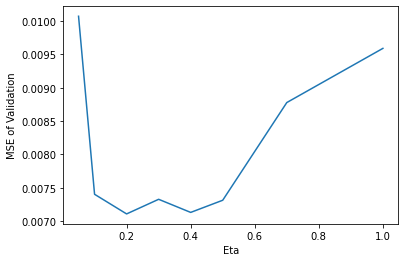

In [54]:
plt.plot(eta_values, results)
plt.xlabel("Eta")
plt.ylabel("MSE of Validation")
plt.show()

In [55]:
# Using 'eta' == 0.2 as best value from previous graph

results = []
max_depth = [2,3,4,5,6,7,8,9,10]

for depth in max_depth:    
    xgb_params = {
        'eta': 0.2, 
        'max_depth': depth,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=175)
    y_val_pred = model.predict(dval)
    results.append(mean_squared_error(y_val, y_val_pred))

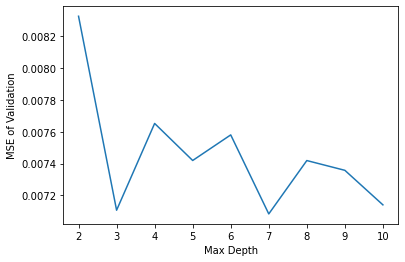

In [56]:
plt.plot(max_depth, results)
plt.xlabel("Max Depth")
plt.ylabel("MSE of Validation")
plt.show()

In [57]:
# Using 'max_depth' == 7 as best value from previous graph

results = []
min_child_weights = [1,2,3,4,5,6,7,8,9,10]

for mcw in min_child_weights:    
    xgb_params = {
        'eta': 0.2, 
        'max_depth': 7,
        'min_child_weight': mcw,

        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=175)
    y_val_pred = model.predict(dval)
    results.append(mean_squared_error(y_val, y_val_pred))

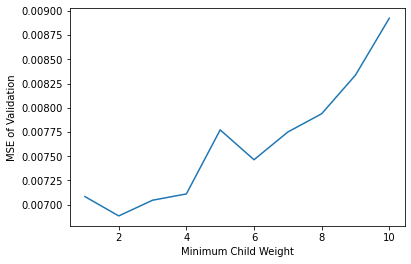

In [58]:
plt.plot(min_child_weights, results)
plt.xlabel("Minimum Child Weight")
plt.ylabel("MSE of Validation")
plt.show()

In [59]:
# Using 'min_child_weight' == 1 as best value from previous graph

train_results = []
val_results = []
n_boost_rounds = [30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]

xgb_params = {
    'eta': 0.2, 
    'max_depth': 7,
    'min_child_weight': 2,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

for nboost in n_boost_rounds:   
    model = xgb.train(xgb_params, dtrain, num_boost_round=nboost)
    y_train_pred = model.predict(dtrain)
    train_results.append(mean_squared_error(y_train, y_train_pred))
    y_val_pred = model.predict(dval)
    val_results.append(mean_squared_error(y_val, y_val_pred))

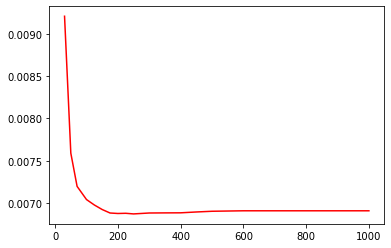

In [60]:
# Lets see when we start to overfit...
# plt.plot(n_boost_rounds, train_results, color='g')
plt.plot(n_boost_rounds, val_results, color='r')
plt.show()

In [61]:
# Best value
print(n_boost_rounds[np.argmin(val_results)])

250


In [62]:
# # Fine tune n_boost.

# train_results = []
# val_results = []
# n_boost_rounds = np.arange(130,171)

# xgb_params = {
#     'eta': 0.3, 
#     'max_depth': 4,
#     'min_child_weight': 3,

#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',

#     'nthread': 8,
#     'seed': 1,
#     'verbosity': 1,
# }

# for nboost in n_boost_rounds:   
#     model = xgb.train(xgb_params, dtrain, num_boost_round=nboost)
#     y_train_pred = model.predict(dtrain)
#     train_results.append(mean_squared_error(y_train, y_train_pred))
#     y_val_pred = model.predict(dval)
#     val_results.append(mean_squared_error(y_val, y_val_pred))

In [63]:
# # Lets see when we start to overfit...
# # plt.plot(n_boost_rounds, train_results, color='g')
# plt.plot(n_boost_rounds, val_results, color='r')
# plt.show()

Now we train on the full train dataset.

In [64]:
y_full_train = df_full_train.pop('target')
df_full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(df_full_train_dicts)

dFullTrain = xgb.DMatrix(X_full_train, label=y_full_train)

xgb_params = {
    'eta': 0.2, 
    'max_depth': 7,
    'min_child_weight': 2,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dFullTrain, num_boost_round=250)

y_full_train_pred = model.predict(dFullTrain)
y_test_pred = model.predict(dtest)
print("Final Training MSE:")
print(mean_squared_error(y_full_train, y_full_train_pred).round(5))
print("Test MSE:")
print(mean_squared_error(y_test, y_test_pred).round(5))

Final Training MSE:
0.00027
Test MSE:
0.00385


We can see that we improved the results with model tuning.

In [65]:
import pickle

In [66]:
with open("bin/xgboost_brazil_house.bin", 'wb') as f:
    pickle.dump(model, f)

In [67]:
with open("bin/dictvec.bin", 'wb') as f:
    pickle.dump(dv, f)

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
rf_model = RandomForestRegressor(n_estimators=200,
                                 max_depth=10,
                                 min_samples_leaf=3,
                                 random_state=19)

rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
print("RF Regressor: Training MSE: ")
mean_squared_error(y_train, y_train_pred).round(4)

RF Regressor: Training MSE: 


0.0062

In [70]:
y_val_pred = rf_model.predict(X_val)
print("RF Regressor: Validation MSE: ")
mean_squared_error(y_val, y_val_pred).round(4)

RF Regressor: Validation MSE: 


0.0136

In [71]:
y_test_pred = rf_model.predict(X_test)
print("RF Regressor: Test MSE: ") 
mean_squared_error(y_test, y_test_pred).round(4)

RF Regressor: Test MSE: 


0.0059

In [72]:
error_list = []
depth_range= np.arange(1,21)
for d in depth_range:
    rf_model = RandomForestRegressor(n_estimators=200,
                                max_depth=d,
                                min_samples_leaf=3,
                                random_state=19)
    rf_model.fit(X_train, y_train)
    y_val_pred = rf_model.predict(X_val)
    error_list.append(mean_squared_error(y_val, y_val_pred))

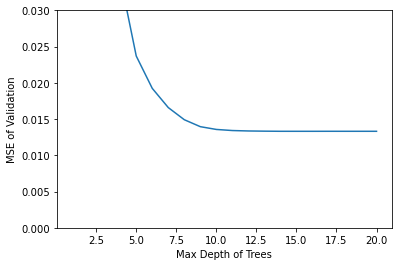

In [73]:
plt.plot(depth_range, error_list)
plt.xlabel("Max Depth of Trees")
plt.ylabel("MSE of Validation")
plt.ylim([0., 0.03])
plt.show()

In [74]:
depth_range[np.argmin(error_list)]
# I think any value between 10 and 20 gives results close... I will go with lowest (complexity): 10.

16

In [75]:
error_list = []
min_sample_leaves = np.arange(1,21)
for msl in min_sample_leaves:
    rf_model = RandomForestRegressor(n_estimators=200,
                                max_depth=10,
                                min_samples_leaf=msl,
                                random_state=19)
    rf_model.fit(X_train, y_train)
    y_val_pred = rf_model.predict(X_val)
    error_list.append(mean_squared_error(y_val, y_val_pred))

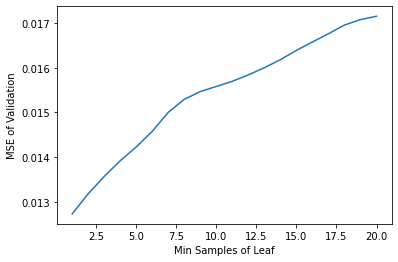

In [76]:
plt.plot(min_sample_leaves, error_list)
plt.xlabel("Min Samples of Leaf")
plt.ylabel("MSE of Validation")
# plt.ylim([0., 0.03])
plt.show()

In [77]:
train_error = []
val_error = []
n_estimators = np.arange(30,451,30)
for N in n_estimators:
    rf_model = RandomForestRegressor(n_estimators=N,
                                max_depth=10,
                                min_samples_leaf=1,
                                random_state=19)
    rf_model.fit(X_train, y_train)
    y_train_pred = rf_model.predict(X_train)
    train_error.append(mean_squared_error(y_train, y_train_pred))
    y_val_pred = rf_model.predict(X_val)
    val_error.append(mean_squared_error(y_val, y_val_pred))

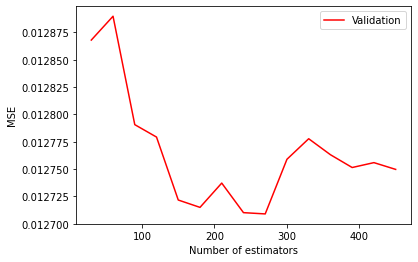

In [78]:
# Lets see when we start to overfit...
# plt.plot(n_estimators, train_error, color='g', label='Train')
plt.plot(n_estimators, val_error, color='r', label='Validation')
plt.xlabel("Number of estimators")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [79]:
n_estimators[np.argmin(val_error)]

270

In [80]:
rf_model = RandomForestRegressor(n_estimators=270,
                            max_depth=10,
                            min_samples_leaf=1,
                            random_state=19)
rf_model.fit(X_full_train, y_full_train)
y_full_train_pred = rf_model.predict(X_full_train)
print("Full Train MSE :")
print(mean_squared_error(y_full_train, y_full_train_pred).round(4))

y_test_pred = rf_model.predict(X_test)
print("Test MSE :")
print(mean_squared_error(y_test, y_test_pred).round(4))

Full Train MSE :
0.0027
Test MSE :
0.0047


In [81]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 270,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 19,
 'verbose': 0,
 'warm_start': False}

In [82]:
with open("bin/sklearn_rf_brazil_house.bin", 'wb') as f:
    pickle.dump(rf_model, f)